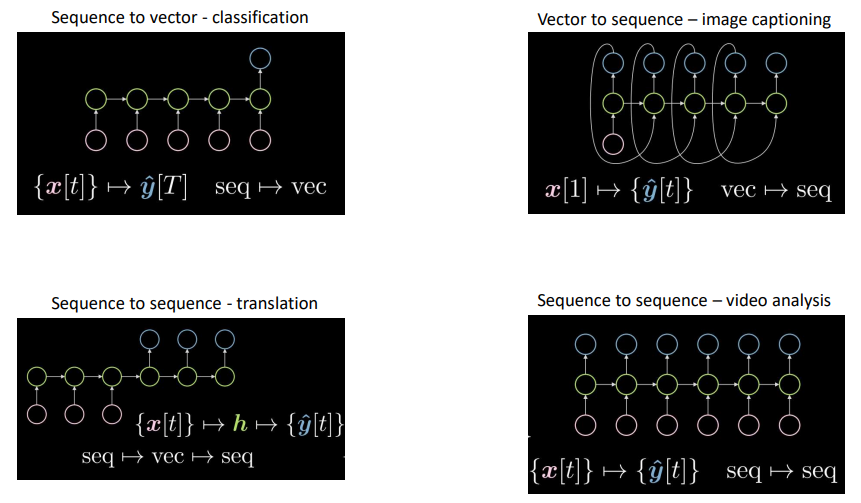

In [ ]:
!wget https://www.ivan-sipiran.com/downloads/nmt_data.zip

--2025-09-23 23:41:27--  https://www.ivan-sipiran.com/downloads/nmt_data.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1229694 (1.2M) [application/zip]
Saving to: ‘nmt_data.zip’

nmt_data.zip        100%[===================>]   1.17M  3.15MB/s    in 0.4s    

2025-09-23 23:41:28 (3.15 MB/s) - ‘nmt_data.zip’ saved [1229694/1229694]



In [ ]:
!unzip nmt_data.zip

Archive:  nmt_data.zip
  inflating: train.fr.txt            
  inflating: val.en.txt              
  inflating: val.fr.txt              
  inflating: test.en.txt             
  inflating: test.fr.txt             
  inflating: train.en.txt            


In [ ]:
!mkdir data
!mv *.txt data/

# Preprocesador de oraciones para Seq2Seq con Atención

Antes de entrenar el modelo, debes preprocesar los datos para alimentar el modelo Seq2Seq.  
Implementa el preprocesador siguiendo las siguientes reglas:

## Reglas de preprocesamiento

1. Todas las palabras deben convertirse en su número de índice correspondiente usando `word2idx`.  
   1.1. Si no existe una palabra en `word2idx`, debes reemplazarla con el token `<UNK>`.  
   1.2. Debes usar el diccionario `word2idx` correspondiente para cada idioma origen/destino.

2. Debes insertar los tokens `<SOS>` (inicio de oración) y `<EOS>` (fin de oración) correctamente en la oración de destino.  
   2.1. No necesitas estos tokens en la oración de origen.

3. La longitud de las oraciones preprocesadas no debe exceder `max_len`.  
   3.1. Si la longitud de la oración excede `max_len`, debes truncar la parte final de la oración.

## Parámetros

- `raw_src_sentence` — oración de origen sin ninguna modificación  
- `raw_trg_sentence` — oración de destino sin ninguna modificación  
- `src_word2idx` — diccionario del idioma origen que asigna a cada palabra un número único  
- `trg_word2idx` — diccionario del idioma destino que asigna a cada palabra un número único  
- `max_len` — longitud máxima de las oraciones

## Retorna

- `src_sentence` — oración de origen preprocesada  
- `trg_sentence` — oración de destino preprocesada


In [ ]:
from typing import List, Dict, Tuple, Sequence, Any
from collections import Counter
from itertools import chain
import random

from collections import defaultdict
import numpy as np
import datetime


import torch

#Clase para un Idioma. Básicamente contiene los diccionarios para convertir palabras a índices y viceversa.
class Language(Sequence[List[str]]):
    # El diccionario contiene los siguientes tokens al inicio (auxiliares)
    PAD_TOKEN = '<PAD>'
    PAD_TOKEN_IDX = 0
    UNK_TOKEN = '<UNK>'
    UNK_TOKEN_IDX = 1
    SOS_TOKEN = '<SOS>' # Start of sentence
    SOS_TOKEN_IDX = 2
    EOS_TOKEN = '<EOS>' # End of sentence
    EOS_TOKEN_IDX = 3

    # 1. Lee un archivo
    # 2. Dividimos una sentencia en una lista de palabras
    def __init__(self, path: str) -> None:
        with open(path, mode='r', encoding='utf-8') as f:
            self._sentences: List[List[str]] = [line.split() for line in f]

        # El índice de una palabra
        self.word2idx: Dict[str, int] = None
        # Para un índice cuál es la palabra
        self.idx2word: List[str] = None

    def build_vocab(self, min_freq: int=2) -> None:
        SPECIAL_TOKENS: List[str] = [Language.PAD_TOKEN, Language.UNK_TOKEN, Language.SOS_TOKEN, Language.EOS_TOKEN]
        # Contamos el número de ocurrencias de una palabra en el texto entero
        # Nos quedamos con las palabras con un cierto nivel de frecuencia
        self.idx2word = SPECIAL_TOKENS + [word for word, count in Counter(chain(*self._sentences)).items() if count >= min_freq]
        self.word2idx = {word: idx for idx, word in enumerate(self.idx2word)}

    def set_vocab(self, word2idx: Dict[str, int], idx2word: List[str]) -> None:
        self.word2idx = word2idx
        self.idx2word = idx2word

    def __getitem__(self, index: int) -> List[str]:
        return self._sentences[index]

    def __len__(self) -> int:
        return len(self._sentences)

#Función que preprocesa las secuencias de entrada y retorna secuencias de índices numéricos
def preprocess(
    raw_src_sentence: List[str], #Secuencia source original
    raw_trg_sentence: List[str], #Secuencia target original
    src_word2idx: Dict[str, int], #Diccionario de idioma source
    trg_word2idx: Dict[str, int], #Diccionario de idioma target
    max_len: int #Máxima longitud de secuencia.
) -> Tuple[List[int], List[int]]: # Retorna dos listas que representan las secuencias, pero con números

    # Special tokens, use these notations if you want
    UNK = Language.UNK_TOKEN_IDX # Índice para tokens desconocidos (que no están en el diccionario)
    SOS = Language.SOS_TOKEN_IDX # Índice para inicio de secuencias
    EOS = Language.EOS_TOKEN_IDX # Índice para fin de secuencias

    #Se declaran las listas de salida
    src_sentence: List[int] = None
    trg_sentence: List[int] = None

    # Truncar secuencias.
    # La secuencia origen se trunca a max_len palabras
    # La secuencia target se trunca a max_len-2 palabras, eso es porque además hay que agregar <SOS> y <EOS> a la secuencia
    truncated_src_sentence = raw_src_sentence[:max_len] if len(raw_src_sentence) > max_len else raw_src_sentence
    truncated_tgt_sentence = raw_trg_sentence[:max_len-2] if len(raw_trg_sentence) > max_len-2 else raw_trg_sentence

    # Convertir las secuencias a números. Palabras desconocidas se identifican con <UNK>
    src_sentence = [src_word2idx[word] if word in src_word2idx.keys() else UNK for word in truncated_src_sentence]
    trg_sentence = [trg_word2idx[word] if word in trg_word2idx.keys() else UNK for word in truncated_tgt_sentence]

    # Insertar <SOS> y <EOS> a la secuencia target
    trg_sentence.insert(0, SOS)
    trg_sentence.append(EOS)

    #Retornar las secuencias numéricas
    return src_sentence, trg_sentence



# Función para índices de batch con agrupamiento (bucketed)

Aunque el cálculo de la pérdida no considera los tokens `<PAD>`, en la práctica estos ocupan recursos de la GPU y degradan el rendimiento.  
Por ello, el número de tokens `<PAD>` en un batch debe minimizarse para maximizar la utilización de la GPU.

Implementa una función que agrupe muestras en batches de forma que el número de tokens `<PAD>` necesarios en cada oración sea menor o igual a `max_pad_len`.

## Notas

- **Nota 1**: está permitido tener varios batches pequeños con menos muestras que `batch_size`, pero no deberían ser muchos. Si pasas el test, entonces está "ok".

- **Nota 2**: puedes aplicar esta función directamente en `torch.utils.data.DataLoader` usando el argumento `batch_sampler`.  
  Si te interesa, revisa los códigos de prueba.

## Sugerencias

- **Sugerencia 1**: la forma más sencilla de agrupar es usar un enfoque de "ordenar y agrupar", pero pronto notarás que no funciona bien en este caso.  
  La segunda forma más sencilla es usar binning, pero el binning unidimensional no es suficiente ya que hay dos oraciones por muestra.

- **Sugerencia 2**: la clase `defaultdict` de la librería `collections` podría ser útil.

## Parámetros

- `sentence_length` — lista de pares `(longitud_oracion_origen, longitud_oracion_destino)`.
- `batch_size` — tamaño del batch.
- `max_pad_len` — longitud máxima permitida de padding. El número de tokens `<PAD>` necesarios en cada oración no debe exceder este valor.

## Retorna

- `batch_indices_list` — lista de índices para cada batch.  
  Cada elemento debe contener los índices correspondientes en la lista `sentence_length`.

## Ejemplo

Si  
```python
sentence_length = [7, 4, 9, 2, 5, 10],  
batch_size = 3,  
max_pad_len = 3

Entonces una posible salida válida para batch_indices_list es:

[[0, 2, 5], [1, 3, 4]]

porque los índices [0, 2, 5] tienen longitudes similares:
sentence_length[0] = 7, sentence_length[2] = 9, sentence_length[5] = 10.

In [ ]:
def bucketed_batch_indices(
        sentence_length: List[Tuple[int, int]],
        batch_size: int,
        max_pad_len: int
) -> List[List[int]]:

    batch_indices_list: List[List[int]] = None
    sentence_length = torch.LongTensor(sentence_length)
    min_dim0 = min(sentence_length[:,0])
    max_dim0 = max(sentence_length[:,0])
    min_dim1 = min(sentence_length[:,1])
    max_dim1 = max(sentence_length[:,1])
    dim0_bin = list(range(min_dim0, max_dim0, max_pad_len))
    dim1_bin = list(range(min_dim1, max_dim1, max_pad_len))

    bin =  []
    for i in dim0_bin:
        for j in dim1_bin:
            elem = (i,j)
            bin.append(torch.LongTensor(elem))
    bin = torch.stack(bin)
    diff = []
    for i in range(len(bin)):
        diff.append(sentence_length-bin[i])
    diff = torch.stack(diff)
    mask_dim1 = (diff[:, :, 0] <= 5) * (0 <= diff[:, :, 0])
    mask_dim2 = (diff[:, :, 1] <= 5) * (0 <= diff[:, :, 1])
    mask = mask_dim1 * mask_dim2
    mask = mask.transpose(0,1)
    bin_id_per_sentence = [int(mask[i].nonzero()[0]) for i in range(len(mask))]
    sentence_idx = range(len(sentence_length))
    dict = defaultdict(list)
    for d0, d1 in zip(bin_id_per_sentence,sentence_idx):
        dict[d0].append(d1)

    list1 = dict.values()
    list2 = []
    for bin in list1:
        n_batches = len(bin)//batch_size
        namuji = len(bin)%batch_size
        tmp_list = [bin[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]
        list2 += tmp_list
        if namuji != 0:
            last_batch = bin[n_batches*batch_size:]
            list2.append(last_batch)

    batch_indices_list = list2

    # Don't forget shuffling batches because length of each batch could be biased
    random.shuffle(batch_indices_list)

    return batch_indices_list


# Función `collate_fn`

Dado que cada oración tiene una longitud variable, debes combinarlas en un solo batch utilizando tokens `<PAD>`.  
Implementa la función `collate_fn`, la cual agrupa oraciones de origen/destino en batches, añadiendo tokens `<PAD>` al final de cada una.

Además, para facilitar las implementaciones posteriores, debes ordenar las oraciones dentro de cada batch en orden descendente según la longitud de la oración de origen.

## Notas

- **Nota 1**: si tienes experiencia con datos de series temporales, sabrás que un tensor con forma `[sequence_length, batch_size, ...]` es mucho más rápido que `[batch_size, sequence_length, ...]`.  
  Sin embargo, para facilitar la comprensión, usaremos `batch_first` en esta ocasión.

- **Nota 2**: puedes aplicar esta función directamente en `torch.utils.data.DataLoader` usando el argumento `collate_fn`.  
  Si te interesa, revisa los códigos de prueba.

## Sugerencia

- La función `torch.nn.utils.rnn.pad_sequence` puede ser útil.

## Parámetros

- `batched_samples` — lista de pares `(oración_origen, oración_destino)`. Esta lista debe convertirse en un batch.

## Retorna

- `src_sentences` — batch de oraciones de origen  
  con forma `(batch_size, longitud_máxima_oración_origen)`

- `trg_sentences` — batch de oraciones de destino  
  con forma `(batch_size, longitud_máxima_oración_destino)`


In [ ]:
def collate_fn(
    batched_samples: List[Tuple[List[int], List[int]]]
) -> Tuple[torch.Tensor, torch.Tensor]:

    PAD = Language.PAD_TOKEN_IDX
    batch_size = len(batched_samples)

    src_sentences: torch.Tensor = None
    trg_sentences: torch.Tensor = None
    src = [sample[0] for sample in batched_samples]
    tgt = [sample[1] for sample in batched_samples]
    src_lengths = [len(sample) for sample in src]
    tgt_lengths = [len(sample) for sample in tgt]
    max_src_len = max(src_lengths)
    max_tgt_len = max(tgt_lengths)
    for i in range(len(batched_samples)):
        src[i] = np.asarray(src[i], dtype=np.int64)
        src[i] = np.pad(src[i], (0, max_src_len-len(src[i])), mode="constant", constant_values=PAD)
        tgt[i] = np.asarray(tgt[i], dtype=np.int64)
        tgt[i] = np.pad(tgt[i], (0, max_tgt_len-len(tgt[i])), mode="constant", constant_values=PAD)

    src_sentences = torch.LongTensor(src)
    trg_sentences = torch.LongTensor(tgt)

    _, sorted_indices = torch.sort(torch.LongTensor(src_lengths), dim=0, descending=True)
    src_sentences = src_sentences.index_select(0, sorted_indices)
    trg_sentences = trg_sentences.index_select(0, sorted_indices)

    assert src_sentences.shape[0] == batch_size and trg_sentences.shape[0] == batch_size
    assert src_sentences.dtype == torch.long and trg_sentences.dtype == torch.long
    return src_sentences, trg_sentences


In [ ]:
#Clase para un dataset de traducción. Recibe dos lenguajes.
class NmtDataset(Sequence[Tuple[List[int], List[int]]]):
    def __init__(self, src: Language, trg: Language, max_len: int=30) -> None:
        assert len(src) == len(trg)
        assert src.word2idx is not None and trg.word2idx is not None

        self._src = src
        self._trg = trg
        self._max_len = max_len

    #Preprocesa dos sentencias y las retorna
    def __getitem__(self, index: int) -> Tuple[List[str], List[str]]:
        return preprocess(self._src[index], self._trg[index], self._src.word2idx, self._trg.word2idx, self._max_len)

    def __len__(self) -> int:
        return len(self._src)

In [ ]:
from abc import ABC, abstractmethod
import random

import torch
import torch.nn as nn

class AttentionBase(nn.Module, ABC):
    @abstractmethod
    def forward(self, encoder_hidden: torch.Tensor, encoder_mask: torch.Tensor, decoder_hidden: torch.Tensor, decoder_mask: torch.Tensor):

      """ Función abstracta de atención (forward)
    Tu función `forward` debe seguir los siguientes parámetros y valores de retorno.
    Para fines de visualización, debes retornar también la distribución de atención.

    Parámetros:
    encoder_hidden -- es el estado oculto del codificador, correspondiente a h^enc en el apunte
                      con forma (batch_size, encoder_sequence_length, hidden_dim)
                      Todos los valores en la última dimensión (hidden_dim) son ceros en las posiciones <PAD>.

    encoder_mask -- es la máscara de <PAD> para el codificador
                    con forma (batch_size, sequence_length) y tipo torch.bool
                    `True` para posiciones <PAD> y `False` para no-<PAD>
                    Equivale a (encoder_hidden == 0.).all(-1)

    decoder_hidden -- es el estado oculto del decodificador, correspondiente a h^dec_t en el apunte
                      con forma (batch_size, hidden_dim)
                      Todos los valores en la última dimensión (hidden_dim) son ceros en las posiciones <PAD>.

    decoder_mask -- es la máscara de <PAD> para el decodificador
                    con forma (batch_size, ) y tipo torch.bool
                    `True` para posiciones <PAD> y `False` para no-<PAD>
                    Equivale a (decoder_hidden == 0.).all(-1)

    Retorna:
    attention (contexto) -- resultado del mecanismo de atención, correspondiente a a_t en el apunte
                             con forma (batch_size, hidden_dim)

    distribution (pesos de atención) -- distribución de atención, correspondiente a alpha_t en el apunte
                                        con forma (batch_size, encoder_sequence_length)
    """

      pass

#Atención basada en producto interno
class DotAttention(AttentionBase):
    def forward(self,
        encoder_hidden: torch.Tensor, #Tensor con todos los estados ocultos del encoder
        encoder_mask: torch.Tensor, #Máscara que indica en dónde hay tokens <PAD>
        decoder_hidden: torch.Tensor,
        decoder_mask: torch.Tensor
    ):
        """ Atención por producto punto (dot product attention)
    Implementa el mecanismo de atención por producto punto, el cual comprime `encoder_output` a lo largo del eje de `sequence_length` utilizando `decoder_output`.

    Nota 1: la salida debe prestar atención solo a las palabras de `encoder_output` que no sean <PAD>.

    Sugerencia: la forma más sencilla de hacer que ALGO tenga probabilidad cero es
    asignar a los resultados de ALGO el valor `-infinito` usando
    `result[ALGO] = float('-inf')` y luego aplicar `softmax` sobre esa dimensión.

    Parámetros / Retornos: los mismos que en la función `forward` de la clase base `Attention`.
    """

        batch_size, sequence_length, hidden_dim = encoder_hidden.shape

        assert (encoder_mask == (encoder_hidden == 0.).all(-1)).all()
        assert (decoder_mask == (decoder_hidden == 0.).all(-1)).all()

        attention: torch.Tensor = None #Resultado de la atención
        distribution: torch.Tensor = None #Distribución de atención
        attention_energy = encoder_hidden.bmm(decoder_hidden.unsqueeze(-1)).squeeze(2) # Producto interno entre estados ocultos del encoder y estado oculto del decoder
        attention_energy[encoder_mask] = float('-inf') #Aquellas posiciones con máscara se cambian por -Inf
        distribution = torch.nn.functional.softmax(attention_energy, dim=1) #Se calcula softmax. Los valores con -Inf -> cero
        attention = encoder_hidden.transpose(1, 2).bmm(distribution.unsqueeze(-1)).squeeze(2) #Vector de atención es la suma ponderada de estados ocultos con pesos de distribución de atención

        assert attention.shape == torch.Size([batch_size, hidden_dim])
        assert distribution.shape == torch.Size([batch_size, sequence_length])

        # Don't forget setting results of decoder <PAD> token values to zeros.
        # This would be helpful for debuging and other implementation details.
        attention[decoder_mask, :] = 0. #Si el decoder está procesando un <PAD>, se anula la atención

        return attention, distribution

#Atención aditiva
class ConcatAttention(AttentionBase):
    def __init__(self, hidden_dim):
        """ Concat attention initializer
        Because there are variables in concat attention, you would need following attributes.
        Use these attributes in forward function

        Attributes:
        W_a -- Attention weight in the handout
                in shape (hidden_dim, 4 * hidden_dim)
        v_a -- Attention vector in the handout
                in shape (hidden_dim, )
        """
        super().__init__()

        self.W_a = nn.Parameter(torch.empty([hidden_dim, 4 * hidden_dim]))
        self.v_a = nn.Parameter(torch.empty([hidden_dim]))

        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.W_a.data)
        nn.init.normal_(self.v_a.data)

    def forward(self,
        encoder_hidden: torch.Tensor,
        encoder_mask: torch.Tensor,
        decoder_hidden: torch.Tensor,
        decoder_mask: torch.Tensor
    ):
        """ Función `forward` de atención por concatenación (concat attention)
    Implementa el mecanismo de atención por concatenación, el cual comprime `encoder_output` a lo largo del eje `sequence_length` utilizando `decoder_output`.

    Parámetros / Retornos: los mismos que en la función `forward` de la clase base `Attention`.
    """

        batch_size, sequence_length, hidden_dim = encoder_hidden.shape

        assert (encoder_mask == (encoder_hidden == 0.).all(-1)).all()
        assert (decoder_mask == (decoder_hidden == 0.).all(-1)).all()

        attention: torch.Tensor = None
        distribution: torch.Tensor = None

        decoder_hidden_expand = decoder_hidden.unsqueeze(dim=1).expand(batch_size,sequence_length,hidden_dim)
        concat_hidden = torch.cat((encoder_hidden, decoder_hidden_expand), dim=-1) #Se concatenan los estados ocultos
        C = concat_hidden.matmul(self.W_a.transpose(0,1)) #Se multiplican por la matriz W
        tanh_C = torch.tanh(C) # Se calcula Tanh
        attention_energy = tanh_C.matmul(self.v_a) # Se multiplican por V
        attention_energy[encoder_mask] = float('-inf') # Se anulan los datos con máscara
        distribution = torch.nn.functional.softmax(attention_energy, dim=1) #Softmax
        attention = encoder_hidden.transpose(1, 2).bmm(distribution.unsqueeze(-1)).squeeze(-1) #Cálculo de atención

        if attention.shape != torch.Size([batch_size, hidden_dim]):
            assert True
        assert distribution.shape == torch.Size([batch_size, sequence_length])

        # Don't forget setting results of decoder <PAD> token values to zeros.
        # This would be helpful for debuging and other implementation details.
        attention[decoder_mask, :] = 0.

        return attention, distribution

In [ ]:
import random

import torch
import torch.nn as nn


import numpy as np

# Creamos la red neuronal para Neural Machine Translation
# Recibe los dos idiomas, el tipo de atención
class Seq2Seq(torch.nn.Module):
    def __init__(self, src: Language, trg: Language, attention_type: str, embedding_dim: int=128, hidden_dim: int=64):
        """ Modelo Seq2Seq con atención (Attention)

    Parámetros:
    src -- vocabulario del idioma de origen
    trg -- vocabulario del idioma de destino
    attention_type -- tipo de atención interna: 'dot' o 'concat'
    embeding_dim -- dimensión del embedding
    hidden_dim -- dimensión oculta
    """

        super().__init__()
        PAD = Language.PAD_TOKEN_IDX
        SRC_TOKEN_NUM = len(src.idx2word) # Including <PAD>
        TRG_TOKEN_NUM = len(trg.idx2word) # Including <PAD>

        self.src_embedding: nn.Embedding = None
        self.trg_embedding: nn.Embedding = None

        self.src_embedding = nn.Embedding(SRC_TOKEN_NUM, embedding_dim=embedding_dim, padding_idx=PAD)
        self.trg_embedding = nn.Embedding(TRG_TOKEN_NUM, embedding_dim=embedding_dim, padding_idx=PAD)

        ### Declarar capas LSTM/LSTMCell
        # Doc for LSTM Layer: https://pytorch.org/docs/stable/nn.html#lstm
        # Doc for LSTMCell Layer: https://pytorch.org/docs/stable/nn.html#lstmcell
        # Explanation for bidirection RNN in torch by @ceshine_en (English): https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
        #
        # Nota 1: No olvides establecer la opción batch_first, ya que nuestros tensores siguen la forma [batch_size, sequence_length, ...].
        # Nota 2: Usa una LSTM de una sola capa con sesgo (bias) tanto para el codificador como para el decodificador.

        self.encoder: nn.LSTM = None
        self.decoder: nn.LSTMCell = None

        #El encoder es un LSTM de una sola capa y bidireccional
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bias=True, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTMCell(embedding_dim, hidden_dim*2, bias=True) #El decoder es una celda LSTM que va procesando la secuencia paso a paso
        # Attention Layer
        if attention_type == 'dot':
            self.attention: AttentionBase = DotAttention()
        elif attention_type == 'concat':
            self.attention: AttentionBase = ConcatAttention(hidden_dim)

        ### Declarar capas de salida
        # Capas de salida para obtener el vector de salida combinada o_t, como se indica en el apunte.
        # Documentación para la capa Sequential: https://pytorch.org/docs/stable/nn.html#sequential
        # Documentación para la capa Linear: https://pytorch.org/docs/stable/nn.html#linear
        # Documentación para la capa Tanh: https://pytorch.org/docs/stable/nn.html#tanh
        #
        # Nota: La forma del vector de salida combinada o_t debe ser (batch_size, TRG_TOKEN_NUM - 1)
        # porque se excluirá la probabilidad del token <PAD>.

        self.output: nn.Sequential = None

        #La MLP de salida termina con una capa de tantas neuronas como tokens hay en en el idioma target (básicamente es una clasificación de palabras)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim, bias=False),
            nn.Tanh(),
            nn.Linear(hidden_dim, TRG_TOKEN_NUM - 1, bias=False)
        )


    def forward(self, src_sentences: torch.Tensor, trg_sentences: torch.Tensor, teacher_force: float=.5):
        """ Función `forward` del modelo Seq2Seq

        Parámetros:
        src_sentences -- batch de oraciones de origen
                          con forma (batch_size, sentence_length)
        trg_sentences -- batch de oraciones de destino
                          con forma (batch_size, sentence_length)
        teacher_force -- probabilidad de aplicar teacher forcing

        Retorna:
        loss -- pérdida promedio por palabra que no sea <PAD>
        """

        # You may use below notations
        batch_size = src_sentences.shape[0]
        PAD = Language.PAD_TOKEN_IDX
        SOS = Language.SOS_TOKEN_IDX
        EOS = Language.EOS_TOKEN_IDX

        encoder_masks = src_sentences == PAD #La máscara del encoder tiene 1's en donde haya <PAD> en la secuencia de entrada

        ### Parte del codificador (~7 líneas)
        # Recomendamos encarecidamente usar torch.nn.utils.rnn.pack_padded_sequence / pad_packed_sequence
        # para manejar los tokens <PAD> y mejorar el rendimiento.
        # Documentación de pack_padded_sequence: https://pytorch.org/docs/stable/nn.html#pack-padded-sequence
        # Documentación de pad_packed_sequence: https://pytorch.org/docs/stable/nn.html#pad-packed-sequence
        # Dado que ya ordenaste las oraciones en la función `collate_fn`, puedes usar pack_padded_sequence sin modificaciones.

        # Variables:
        # encoder_hidden -- estado oculto del codificador
        #                   con forma (batch_size, sequence_length, hidden_dim)
        #                   Todos los valores en la última dimensión (hidden_dim) son ceros en las posiciones <PAD>.
        # hidden_state -- último estado oculto del codificador
        #                 con forma (batch_size, hidden_dim * 2)
        # cell_state -- último estado de celda del codificador
        #               con forma (batch_size, hidden_dim * 2)

        encoder_hidden: torch.Tensor = None
        hidden_state: torch.Tensor = None
        cell_state: torch.Tensor = None

        src_embedding_seq = self.src_embedding(src_sentences) #Se le aplica el embedding a la sentencia source
        src_lengths = (src_sentences != 0).sum(dim=1).cpu()
        packed_seq = torch.nn.utils.rnn.pack_padded_sequence(src_embedding_seq, src_lengths, batch_first=True, enforce_sorted=True)

        encoder_hidden_states, (hidden_state, cell_state) = self.encoder(packed_seq) #Se ejecuta el encoder
        encoder_hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(encoder_hidden_states,
                                                                                 batch_first=True, padding_value=PAD)
        encoder_hidden[encoder_masks] = 0.

        # Loss initialize
        decoder_out = trg_sentences.new_full([batch_size], fill_value=SOS) #La primera entrada del decoder es <SOS>
        decoder_c0 = torch.cat((cell_state[0], cell_state[1]), dim=1) #Primera entrada de memoria C para el decoder
        decoder_h0 = torch.cat((hidden_state[0], hidden_state[1]), dim=1) #Primera entrada de H para el decoder
        sum_of_loss = 0.
        ce_loss = nn.CrossEntropyLoss(ignore_index=PAD, reduction='sum') #CEL no se aplica sobre elementos con <PAD>
        #Este bucle recorre cada palabra del target
        for trg_word_idx in range(trg_sentences.shape[1] - 1):
            # Teacher forcing: feed correct labels with a probability of teacher_force
            #Se decide si usar la salida previa del decoder o la palabra de la secuencia target: Teacher forcing
            decoder_input = trg_sentences[:, trg_word_idx] if torch.distributions.bernoulli.Bernoulli(teacher_force).sample() else decoder_out
            decoder_input_embedding = self.trg_embedding(decoder_input)  # Se calcula el embedding de la palabra actual
            decoder_h0, decoder_c0 = self.decoder(decoder_input_embedding, (decoder_h0, decoder_c0)) #La entrada a la celda LSTM es el embedding, la memoria y el estado oculto H
            decoder_mask = trg_sentences[:, trg_word_idx + 1] == PAD #Se anulan los datos que pertenecen a <PAD>
            decoder_h0[decoder_mask] = 0.

            #Se calcula la atención entre los estados ocultos del encoder y el estado oculto actual del decoder
            attention_output, distribution = self.attention(encoder_hidden, encoder_masks, decoder_h0, decoder_mask)

            #Se concatenan el estado oculto y la salida de la atención
            output_layer_input = torch.cat((decoder_h0, attention_output), dim=1)
            output_logit = self.output(output_layer_input) #Se ejecuta el MLP para generar la salida de la actual palabra

            # You may use below notations
            decoder_target = trg_sentences[:, trg_word_idx+1] #Esta es la palabra que debería haber salido
            decoder_out = torch.argmax(output_logit, dim=1) + 1 #Se calcula la predicción
            tmp = output_logit.new_full((batch_size, 1), fill_value=float('-inf'))
            new_logit = torch.cat((tmp, output_logit), dim=1)
            loss = ce_loss(new_logit, decoder_target) #Se calcula el loss
            sum_of_loss += loss #Se acumula el loss

        loss = sum_of_loss
        assert loss.shape == torch.Size([])
        return loss / (trg_sentences[:, 1:] != PAD).sum() # Return average loss per a non-<PAD> word

    def translate(self, sentence: torch.Tensor, max_len: int=30):
        """
          Parámetros:
          sentence -- oración a ser traducida
                      con forma (sentence_length, )
          max_len -- longitud máxima de palabras de la oración traducida

          Retorna:
          translated -- oración traducida
                        con forma (translated_length, ), donde translated_length <= max_len
                        de tipo torch.long

          distributions -- distribuciones de atención apiladas
                        con forma (translated_length, sentence_length)
                        Esto se utiliza para visualización (plotting)
          """

        PAD = Language.PAD_TOKEN_IDX
        SOS = Language.SOS_TOKEN_IDX
        EOS = Language.EOS_TOKEN_IDX
        sentence_length = sentence.size(0)

        # Note: use argmax to get the next input word
        translated =[]
        distributions = []

        src_embedding_seq = self.src_embedding(sentence).unsqueeze(0)
        src_lengths = sentence_length

        encoder_hidden_states, (hidden_state, cell_state) = self.encoder(src_embedding_seq)
        encoder_hidden=encoder_hidden_states

        # Loss initialize
        decoder_out = sentence.new_full([1], fill_value=SOS)
        decoder_c0 = torch.cat((cell_state[0], cell_state[1]), dim=1)
        decoder_h0 = torch.cat((hidden_state[0], hidden_state[1]), dim=1)
        encoder_masks = (sentence == PAD).unsqueeze(0)
        decoder_mask = False
        for trg_word_idx in range(max_len):
            decoder_input = decoder_out
            decoder_input_embedding = self.trg_embedding(decoder_input)  # y_t
            decoder_h0, decoder_c0 = self.decoder(decoder_input_embedding, (decoder_h0, decoder_c0))

            decoder_h0[decoder_mask] = 0.
            attention_output, distribution = self.attention(encoder_hidden, encoder_masks, decoder_h0, decoder_mask)

            output_layer_input = torch.cat((decoder_h0, attention_output), dim=1)
            output_logit = self.output(output_layer_input)

            decoder_out = torch.argmax(output_logit, dim=1) + 1
            translated.append(decoder_out)
            distributions.append(distribution.squeeze(0))
            if decoder_out == EOS:
                break
        translated = torch.stack(translated).squeeze(1)
        distributions = torch.stack(distributions)

        assert translated.dim() == 1 and distributions.shape == torch.Size([translated.size(0), sentence_length])
        return translated, distributions

In [ ]:
from typing import List

import torch
import datetime
import torch.utils
import random
from tqdm import tqdm, trange

import matplotlib
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

attention_type = 'concat' # 'dot' or 'concat'
embedding_dim = 128
hidden_dim = 64
bucketing = True

def plot_attention(attention: torch.Tensor, trg_text: List[str], src_text: List[str], name: str):
    assert attention.shape[0] == len(trg_text) and attention.shape[1] == len(src_text)
    _, ax = plt.subplots()
    _ = ax.pcolor(attention)

    ax.set_xticks([tick + .5 for tick in range(len(src_text))], minor=False)
    ax.set_yticks([tick + .5 for tick in range(len(trg_text))], minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(src_text, rotation=90, minor=False)
    ax.set_yticklabels(trg_text, minor=False)
    plt.savefig('attention_' + name + '.png')

def load_model():
    french = Language(path='data/train.fr.txt')
    english = Language(path='data/train.en.txt')
    french.build_vocab()
    english.build_vocab()
    dataset = NmtDataset(src=french, trg=english)
    model = Seq2Seq(french, english, attention_type=attention_type,
                    embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)
    model.load_state_dict(torch.load('/home/admin/projects/ai605/assn2/seq2seq_concat.pth'))
    model.eval()

def train():
    max_epoch = 200
    batch_size = 256

    french = Language(path='data/train.fr.txt')
    english = Language(path='data/train.en.txt')
    french.build_vocab()
    english.build_vocab()
    dataset = NmtDataset(src=french, trg=english)

    max_pad_len = 5
    sentence_length = list(map(lambda pair: (len(pair[0]), len(pair[1])), dataset))
    batch_sampler = bucketed_batch_indices(sentence_length, batch_size=batch_size, max_pad_len=max_pad_len) if bucketing else None

    model = Seq2Seq(french, english, attention_type=attention_type, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, num_workers=2, batch_size=1 if bucketing else batch_size, batch_sampler=batch_sampler, shuffle=not bucketing)

    loss_log = tqdm(total=0, bar_format='{desc}', position=0)
    for epoch in trange(max_epoch, desc="Epoch", position=0):
        for src_sentence, trg_sentence in tqdm(dataloader, desc="Iteration", position=0):
            optimizer.zero_grad()
            src_sentence, trg_sentence = src_sentence.to(device), trg_sentence.to(device)
            loss = model(src_sentence, trg_sentence, teacher_force=0.5)
            loss.backward()
            optimizer.step()

            des = 'Loss per a non-<PAD> Word: {:06.4f}'.format(loss.cpu())
            loss_log.set_description_str(des)

    torch.save(model.state_dict(), "seq2seq_" + attention_type + ".pth")

def translate():
    SOS = Language.SOS_TOKEN_IDX
    EOS = Language.EOS_TOKEN_IDX

    french_train = Language(path='data/train.fr.txt')
    english_train = Language(path='data/train.en.txt')
    french_train.build_vocab()
    english_train.build_vocab()
    model = Seq2Seq(french_train, english_train, attention_type=attention_type,
                    embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)
    model.load_state_dict(torch.load("seq2seq_" + attention_type + ".pth", map_location=device))

    french_test = Language(path='data/test.fr.txt')
    english_test = Language(path='data/test.en.txt')
    french_test.set_vocab(french_train.word2idx, french_train.idx2word)
    english_test.set_vocab(english_train.word2idx, english_train.idx2word)
    dataset = NmtDataset(src=french_test, trg=english_test)

    samples = [dataset[16][0], dataset[1][0], dataset[2][0]] # You may choose your own samples to plot

    for i, french in enumerate(samples):
        translated, attention = model.translate(torch.Tensor(french).to(dtype=torch.long, device=device))
        source_text = [french_train.idx2word[idx] for idx in french]
        translated_text = [english_train.idx2word[idx] for idx in translated]
        plot_attention(attention.cpu().detach(), translated_text, source_text, name=attention_type + '_' + str(i))

    f = open('translated.txt', mode='w', encoding='utf-8')
    f_bleu = open('pred.en.txt', mode='w', encoding='utf-8')
    for french, english in tqdm(dataset, desc='Translated'):
        translated, attention = model.translate(torch.Tensor(french).to(dtype=torch.long, device=device))
        source_text = [french_train.idx2word[idx] for idx in french]
        target_text = [english_train.idx2word[idx] for idx in english if idx != SOS and idx != EOS]
        translated_text = [english_train.idx2word[idx] for idx in translated if idx != EOS]

        f.write('French    : ' + ' '.join(source_text) + '\n')
        f.write('English   : ' + ' '.join(target_text) + '\n')
        f.write('Translated: ' + ' '.join(translated_text) + '\n\n')
        f_bleu.write(' '.join(translated_text) + '\n')
    f.close()
    f_bleu.close()

2025-09-23 23:42:29.322189


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-524222205.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  src_sentences = torch.LongTensor(src)
/tmp/ipython-input-524222205.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  src_sentences = torch.LongTensor(src)
Iteration:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-524222205.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a 

2025-09-24 00:10:45.833058


Translated: 100%|██████████| 461/461 [00:05<00:00, 77.85it/s]


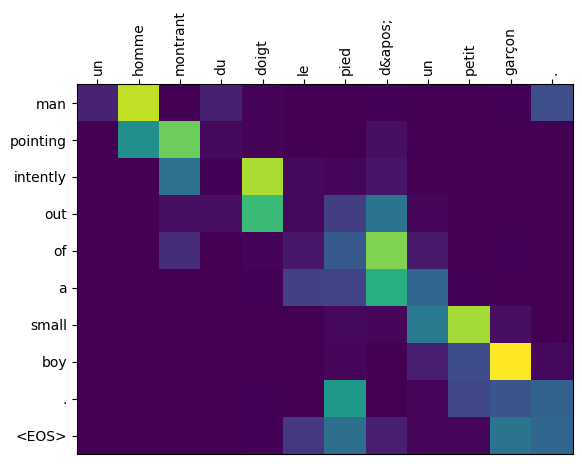

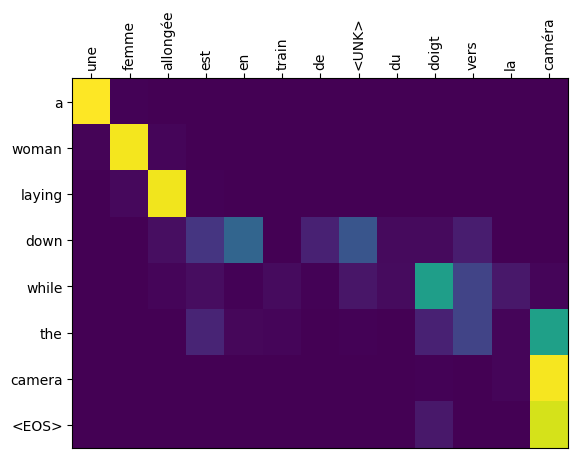

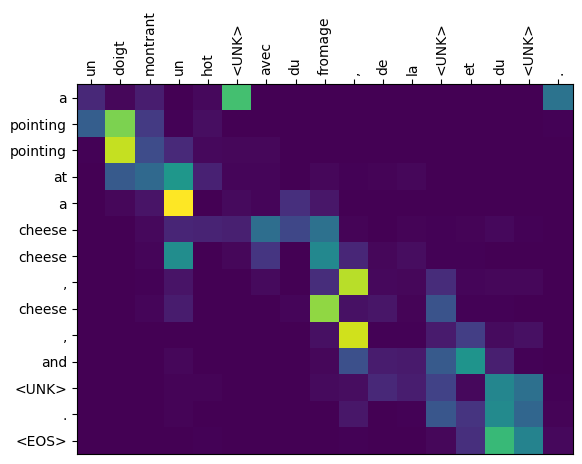

In [ ]:
torch.set_printoptions(precision=8)
random.seed(4321)
torch.manual_seed(4321)
print(datetime.datetime.now())
train()
print(datetime.datetime.now())
translate()